<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

sfrerich

Aim: Preprocess human brain single-cell data from Garcia 2022 Nature  
Publication: https://www.nature.com/articles/s41586-022-04521-7

Also see https://nsun.shinyapps.io/scbbb/ (only showing ex-vivo dataset)

In [1]:
import sys
import os, fnmatch 

In [2]:
import anndata
import scanpy as sc
import scipy as sci
#sc.logging.print_versions()

In [3]:
sc.settings.verbosity = 3

In [4]:
import loompy

In [5]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [6]:
from datetime import date
from matplotlib.pyplot import rc_context

In [7]:
os.getcwd()

'/cluster2/sfrerich/jupyter/p6-foxf2-per-celltype'

In [8]:
main_dir='/run/user/1000/gvfs/smb-share:server=138.245.4.35,share=bd-dichgans/SF' # Linux
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win

In [9]:
main_dir='/cluster2/sfrerich/jupyter/p6-foxf2-per-celltype/data' # HPC

# Load data

Downloaded from http://compbio.mit.edu/scBBB/ (27/02/2023)

In [10]:
# Turn rds to tsv on HPC
# /opt/R/4.0.0/bin/R
# library(data.table)
# 
# main <- "/cluster2/sfrerich/jupyter/p6-foxf2-per-celltype/data/P6_vasc_scRNAseq/"
# 
# f <- readRDS(paste0(main, 'Garcia2022/preprocessed/brain.BBB.human.counts.rds'))
# f <- readRDS(paste0(main, 'Garcia2022/brain.BBB.human.counts.GEOsubmission.rds'))
# f <- readRDS(paste0(main, 'Garcia2022/ROSMAP.VascularCells.counts.rds'))
# m <- readRDS(paste0(main, 'Garcia2022/brain.BBB.human.meta.GEOsubmission.rds')) # export directly
# 
# fd <- as.data.table(as.matrix(f))
# rownames(fd) <- as.data.frame(f@Dimnames[1])[,1] # dense
# colnames(fd) <- as.data.frame(f@Dimnames[2])[,1]
# 
# fwrite(fd, paste0(main, 'Garcia2022/preprocessed/brain.BBB.human.counts.tsv'), sep="\t", row.names=TRUE, col.names=TRUE)
# fwrite(fd, paste0(main, 'Garcia2022/brain.BBB.human.counts.GEOsubmission.tsv'), sep="\t", row.names=TRUE, col.names=TRUE)
# fwrite(fd, paste0(main, 'Garcia2022/ROSMAP.VascularCells.counts.tsv'), sep="\t", row.names=TRUE, col.names=TRUE)
# fwrite(m, paste0(main, 'Garcia2022/brain.BBB.human.meta.GEOsubmission.txt'), sep="\t", col.names=TRUE)

In [11]:
# from base folder
# not annotated / not used

In [12]:
# ad = sc.read_csv(main_dir+"/P6_vasc_scRNAseq/Garcia2022/brain.BBB.human.counts.GEOsubmission.tsv", delimiter="\t").transpose()

In [13]:
#ad

In [14]:
# meta = pd.read_csv(main_dir+'/P6_vasc_scRNAseq/Garcia2022/brain.BBB.human.meta.GEOsubmission.txt', sep='\t')
# meta.head(2)

## ROSMAP dataset

Nonpathological post-mortem brains

In [15]:
# from base folder: ROSMAP study / annotated, vascular cells only

In [16]:
ad_ROSMAP = sc.read_csv(main_dir+"/P6_vasc_scRNAseq/Garcia2022/ROSMAP.VascularCells.counts.tsv", delimiter="\t").transpose()

In [17]:
ad_ROSMAP.obs_names_make_unique()
ad_ROSMAP.var_names_make_unique()

In [18]:
ad_ROSMAP

AnnData object with n_obs × n_vars = 11689 × 33538

In [19]:
ad_ROSMAP.obs.head()

""
SM_171013Tsa.CTACCCAGTGCAACGA-3
SM_171013Tsa.AACTTTCTCTGCAGTA-7
SM_171013Tsa.AGATTGCGTGCAGTAG-7
SM_171013Tsa.CTCTAATAGAAACCAT-15
SM_171013Tsa.GCGCAGTAGGTGCTTT-17


In [20]:
meta_ROSMAP = pd.read_csv(main_dir+'/P6_vasc_scRNAseq/Garcia2022/ROSMAP.VascularCells.meta.txt', sep='\t')
meta_ROSMAP.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,id,library_id,batch,brain_region,projid,percent.mt,RNA_snn_res.0.5,seurat_clusters,celltype,subtype
SM_171013Tsa.CTACCCAGTGCAACGA-3,vascular,1379,1053,3,D17-8755,SM_171013Tsa,Prefrontal_cortex,10260309,0.196078,0,0,Endo,capEndo
SM_171013Tsa.AACTTTCTCTGCAGTA-7,vascular,1704,1174,7,D17-8759,SM_171013Tsa,Prefrontal_cortex,10514454,0.367069,0,0,Endo,capEndo


In [21]:
pd.value_counts(meta_ROSMAP.celltype)

Endo    4345
Fib     3364
Per     3358
SMC      622
Name: celltype, dtype: int64

In [22]:
pd.value_counts(meta_ROSMAP.subtype)

capEndo    2941
Fib1       2073
Per1       1561
Per2       1303
vEndo      1055
Fib2        956
Per3        504
aSMC        426
aEndo       349
Fib3        335
vSMC        186
Name: subtype, dtype: int64

In [23]:
ad_ROSMAP.obs = ad_ROSMAP.obs.join(meta_ROSMAP)

Check if data is normalized:

In [24]:
ad_ROSMAP.layers

Layers with keys: 

In [25]:
ad_ROSMAP.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

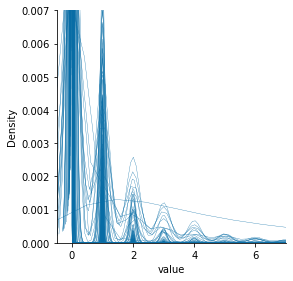

In [26]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, ad_ROSMAP.X.shape[1]), 100)
adata_sub = ad_ROSMAP[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007))
sns.set_theme(style='white')
plt.show()

/tmp/ipykernel_63837/3020484424.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


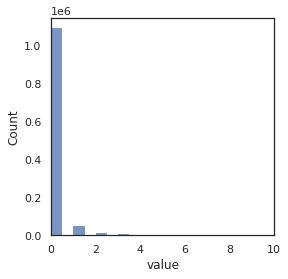

In [27]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10));
plt.show()

Data is not normalized, therefore normalize and log-transform

In [28]:
ad_ROSMAP.layers["counts"] = ad_ROSMAP.X.copy() # save unnormalized raw RNA counts - retrieve via ad.X = ad.layers["counts"]

In [29]:
sc.pp.normalize_total(ad_ROSMAP, inplace=True) # Normalize each spot by total counts over all genes, so that every cell has the same total count after normalization.

normalizing counts per cell
    finished (0:00:00)


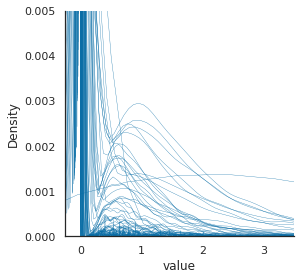

In [30]:
# show expression of 100 random genes (across all spots)
adata_sub = ad_ROSMAP[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005))
plt.show()

/tmp/ipykernel_63837/2747832379.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


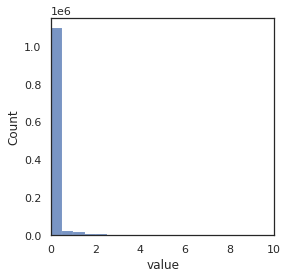

In [31]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10))
plt.show()

In [32]:
sc.pp.log1p(ad_ROSMAP) # X = log(X + 1)

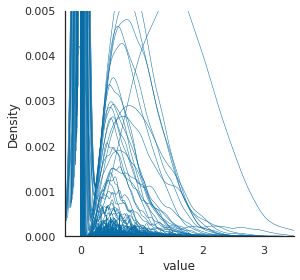

In [33]:
# show expression of 100 random genes (across all spots)
adata_sub = ad_ROSMAP[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.5) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005));
plt.show()

/tmp/ipykernel_63837/2170774648.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));


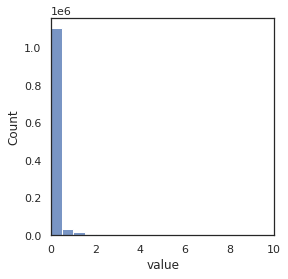

In [34]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));
pl.set(xlim=(0, 10));
plt.show()

In [35]:
ad_ROSMAP.layers["normalized"] = ad_ROSMAP.X.copy() # retrieve via adata.X = adata.layers["normalized"]

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


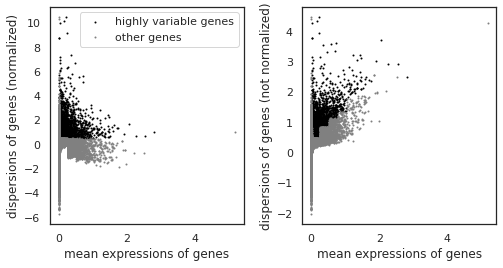

In [36]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(ad_ROSMAP)
sc.pl.highly_variable_genes(ad_ROSMAP)

In [37]:
ad_ROSMAP

AnnData object with n_obs × n_vars = 11689 × 33538
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'id', 'library_id', 'batch', 'brain_region', 'projid', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'celltype', 'subtype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [38]:
ad_ROSMAP.layers

Layers with keys: counts, normalized

In [39]:
pd.value_counts(meta_ROSMAP.celltype)

Endo    4345
Fib     3364
Per     3358
SMC      622
Name: celltype, dtype: int64

In [40]:
# Renaming
old_to_new = {'aEndo':'aECs',
              'capEndo':'capECs',
              'vEndo':'vECs',
              'Per1':'Pericytes',
              'Per2':'Pericytes',
              'Per3':'Pericytes',
              'Fib1':'Fibroblasts',
              'Fib2':'Fibroblasts',
              'Fib3':'Fibroblasts',
              'aSMC':'SMCs',
              'vSMC':'SMCs'}
ad_ROSMAP.obs['clusters2'] = (ad_ROSMAP.obs['subtype'].map(old_to_new).astype('category'))

In [41]:
# Renaming
old_to_new = {'Endo':'ECs',
              'Per':'Pericytes',
              'Fib':'Fibroblasts',
              'SMC':'SMCs'}
ad_ROSMAP.obs['clusters'] = (ad_ROSMAP.obs['celltype'].map(old_to_new).astype('category'))

### Dim Reduction

Nonpathological post-mortem brains

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


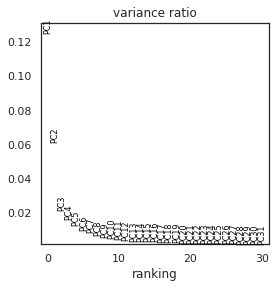

In [42]:
sc.tl.pca(ad_ROSMAP)
sc.pl.pca_variance_ratio(ad_ROSMAP)

In [43]:
sc.pp.neighbors(ad_ROSMAP)
sc.tl.umap(ad_ROSMAP)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


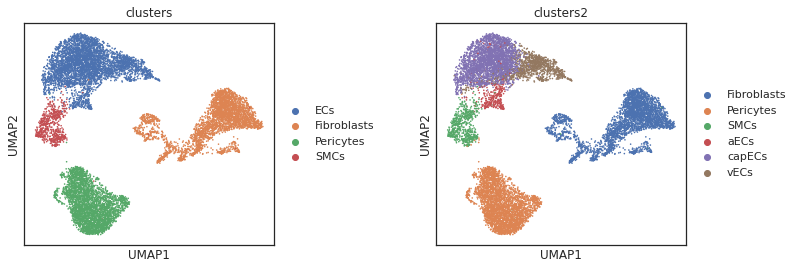

In [44]:
sc.pl.umap(ad_ROSMAP, color=['clusters','clusters2'], wspace=0.5)

### Marker genes

In [45]:
sc.tl.rank_genes_groups(ad_ROSMAP, 'clusters')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`


/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


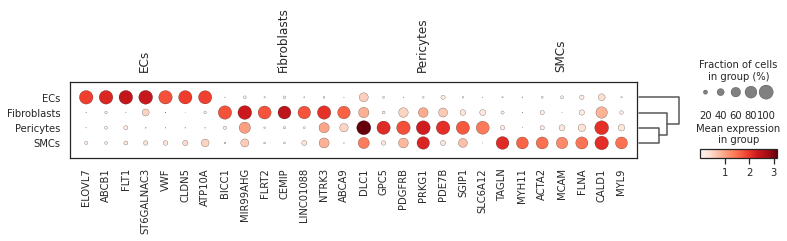

In [46]:
sc.pl.rank_genes_groups_dotplot(ad_ROSMAP,n_genes=7)

### Focus on: Foxf2

In [47]:
gene="FOXF2"

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


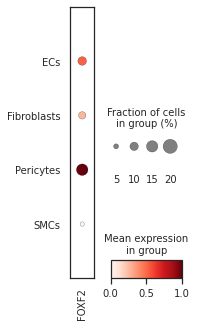

In [50]:
sc.pl.dotplot(ad_ROSMAP, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


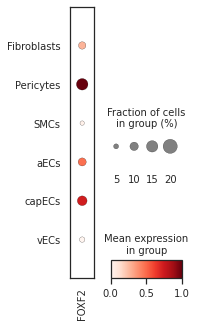

In [51]:
sc.pl.dotplot(ad_ROSMAP, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

## Ex-vivo dataset

Epilepsy patients

In [52]:
# from preprocessed folder:

In [53]:
ad = sc.read_csv(main_dir+"/P6_vasc_scRNAseq/Garcia2022/preprocessed/brain.BBB.human.counts.tsv", delimiter="\t").transpose()

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [54]:
ad.obs_names_make_unique()
ad.var_names_make_unique()

In [55]:
ad

AnnData object with n_obs × n_vars = 84350 × 26812

In [56]:
ad.var.head()

""
AL627309.1
AC114498.1
AL669831.2
AL669831.5
FAM87B


In [57]:
ad.obs.head()

""
D20-125061.23
D20-125061.28
D20-125061.30
D20-125061.32
D20-125061.41


In [58]:
# Add metadata

In [59]:
meta = pd.read_csv(main_dir+'/P6_vasc_scRNAseq/Garcia2022/preprocessed/brain.BBB.human.meta.txt', sep='\t')
meta.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,SampleID,PatientID,snRNAPreparation,percent.mt,RNA_snn_res.0.5,seurat_clusters,celltype,oricluster,newcluster
D20-125061.23,BBB,8865,3521,D20-125061,E381,BVP,0.067682,3,3,Astro,3,4
D20-125061.28,BBB,10148,3902,D20-125061,E381,BVP,0.039417,3,3,Astro,3,4


In [60]:
meta.shape

(84350, 12)

In [61]:
meta2 = pd.read_csv(main_dir+'/P6_vasc_scRNAseq/Garcia2022/preprocessed/brain.BBB.human.vascular.final.Jan2022.metadata.txt', sep='\t')
meta2.index = meta2["orig.ident"]
meta2.index.name = None
meta2.head(2)

,orig.ident,study,nCount_RNA,nFeature_RNA,SampleID,PatientID,snRNAPreparation,percent.mt,seurat_clusters,celltype,cellsubtype
D20-125061.116,D20-125061.116,BBB,3180,1773,D20-125061,E381,BVP,0.143802,3,Endo,aEndo
D20-125061.209,D20-125061.209,BBB,4134,2049,D20-125061,E381,BVP,0.132509,0,Endo,capEndo


In [62]:
meta2.shape

(4992, 11)

In [63]:
pd.value_counts(meta2.cellsubtype)

Per1       1233
capEndo    1220
vEndo       520
aEndo       477
Per2        331
Fib1        314
vSMC        251
Fib2        244
Fib3        235
aSMC        167
Name: cellsubtype, dtype: int64

In [64]:
meta = meta.join(meta2[["cellsubtype"]])

In [65]:
meta['clusters'] = meta['cellsubtype'].fillna(meta['celltype'])

In [66]:
meta.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,SampleID,PatientID,snRNAPreparation,percent.mt,RNA_snn_res.0.5,seurat_clusters,celltype,oricluster,newcluster,cellsubtype,clusters
D20-125061.23,BBB,8865,3521,D20-125061,E381,BVP,0.067682,3,3,Astro,3,4,NaN,Astro
D20-125061.28,BBB,10148,3902,D20-125061,E381,BVP,0.039417,3,3,Astro,3,4,NaN,Astro


In [67]:
ad.obs = ad.obs.join(meta)

In [68]:
ad.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'SampleID', 'PatientID',
       'snRNAPreparation', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters',
       'celltype', 'oricluster', 'newcluster', 'cellsubtype', 'clusters'],
      dtype='object')

In [69]:
ad.obs.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,SampleID,PatientID,snRNAPreparation,percent.mt,RNA_snn_res.0.5,seurat_clusters,celltype,oricluster,newcluster,cellsubtype,clusters
D20-125061.23,BBB,8865.0,3521.0,D20-125061,E381,BVP,0.067682,3.0,3.0,Astro,3.0,4.0,NaN,Astro
D20-125061.28,BBB,10148.0,3902.0,D20-125061,E381,BVP,0.039417,3.0,3.0,Astro,3.0,4.0,NaN,Astro


In [70]:
pd.value_counts(ad.obs["snRNAPreparation"])

BVP      76807
Whole     7531
Name: snRNAPreparation, dtype: int64

In [71]:
pd.value_counts(meta.SampleID)

D20-125072         6656
D20-125073         6340
D20-125065         5746
D20-125071         5566
L425_27_premrna    5379
D20-125064         4966
D20-125069         4920
D20-125070         4371
L425_25_premrna    4134
L425_33_premrna    3983
D20-125061         3972
D20-125067         3822
D20-125063         3470
L425_23_premrna    3208
D20-125068         3006
D20-169011         2427
D20-125062         2210
D20-169013         2174
L425_17_premrna    1853
D20-169016         1688
D20-169015         1540
D20-125066         1528
D20-169012          559
D20-169014          520
D20-169017          277
D20-169010           35
Name: SampleID, dtype: int64

In [72]:
pd.value_counts(ad.obs.PatientID)

E371       7140
E213       6656
E212       6340
E361       6264
E219       5566
E381       5512
E268       5477
E290       5432
L425_27    5379
E232       4406
L425_25    4132
L425_33    3983
E311       3821
E372       3468
L425_23    3208
E379       2208
E181       1965
L425_17    1853
E337       1528
Name: PatientID, dtype: int64

In [73]:
pd.value_counts(ad.obs.celltype)

Oligo        29436
Ex           17357
Astro        11955
Microglia     8166
In            6612
OPC           5844
Vascular      4968
Name: celltype, dtype: int64

In [74]:
pd.value_counts(ad.obs.cellsubtype)

Per1       1233
capEndo    1219
vEndo       520
aEndo       477
Per2        331
Fib1        308
vSMC        250
Fib2        240
Fib3        235
aSMC        167
Name: cellsubtype, dtype: int64

In [75]:
pd.value_counts(ad.obs.clusters)

Oligo        29428
Ex           17356
Astro        11954
Microglia     8164
In            6612
OPC           5844
Per1          1233
capEndo       1219
vEndo          520
aEndo          477
Per2           331
Fib1           308
vSMC           250
Fib2           240
Fib3           235
aSMC           167
Name: clusters, dtype: int64

In [76]:
# Renaming
old_to_new = {'aEndo':'aECs',
              'Astro':'Astrocytes',
              'capEndo':'capECs',
              'vEndo':'vECs',
              'Per1':'Pericytes',
              'Per2':'Pericytes',
              'Microglia':'Microglia',
              'Ex':'Neurons',
              'In':'Neurons',
              'OPC':'OPCs',
              'Fib1':'Fibroblasts',
              'Fib2':'Fibroblasts',
              'Fib3':'Fibroblasts',
              'aSMC':'SMCs',
              'vSMC':'SMCs',
              'Oligo':'Oligos'}
ad.obs['clusters2'] = (ad.obs['clusters'].map(old_to_new).astype('category'))

In [77]:
# Renaming
old_to_new = {'aEndo':'ECs',
              'Astro':'Astrocytes',
              'capEndo':'ECs',
              'vEndo':'ECs',
              'Per1':'Pericytes',
              'Per2':'Pericytes',
              'Microglia':'Microglia',
              'Ex':'Neurons',
              'In':'Neurons',
              'OPC':'OPCs',
              'Fib1':'Fibroblasts',
              'Fib2':'Fibroblasts',
              'Fib3':'Fibroblasts',
              'aSMC':'SMCs',
              'vSMC':'SMCs',
              'Oligo':'Oligos'}
ad.obs['clusters'] = (ad.obs['clusters'].map(old_to_new).astype('category'))

In [78]:
adata=ad

In [79]:
del ad

Check if data is normalized:

In [80]:
adata.layers

Layers with keys: 

In [81]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

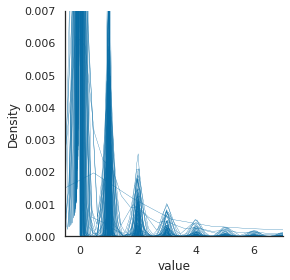

In [82]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, adata.X.shape[1]), 100)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007))
sns.set_theme(style='white')
plt.show()

/tmp/ipykernel_63837/3020484424.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


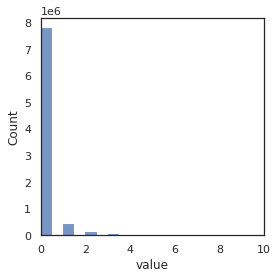

In [83]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10));
plt.show()

Data is not normalized, therefore normalize and log-transform

In [84]:
adata.layers["counts"] = adata.X.copy() # save unnormalized raw RNA counts - retrieve via ad.X = ad.layers["counts"]

In [85]:
sc.pp.normalize_total(adata, inplace=True) # Normalize each spot by total counts over all genes, so that every cell has the same total count after normalization.

normalizing counts per cell
    finished (0:00:00)


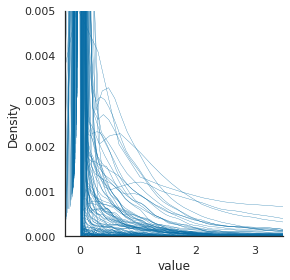

In [86]:
# show expression of 100 random genes (across all spots)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005))
plt.show()

/tmp/ipykernel_63837/2747832379.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


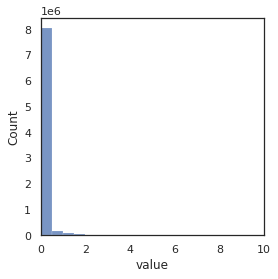

In [87]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10))
plt.show()

In [88]:
sc.pp.log1p(adata) # X = log(X + 1)

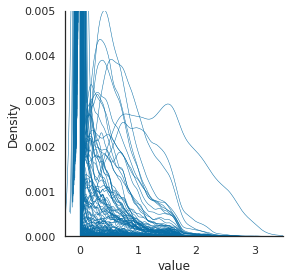

In [89]:
# show expression of 100 random genes (across all spots)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.5) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005));
plt.show()

/tmp/ipykernel_63837/2170774648.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));


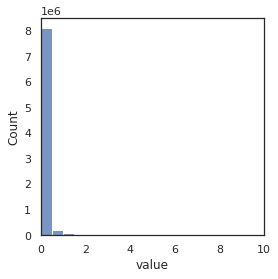

In [90]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));
pl.set(xlim=(0, 10));
plt.show()

In [91]:
adata.layers["normalized"] = adata.X.copy() # retrieve via adata.X = adata.layers["normalized"]

extracting highly variable genes
    finished (0:00:18)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


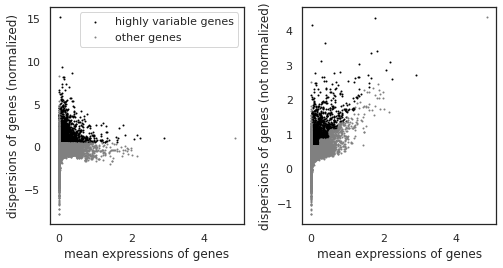

In [92]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [93]:
adata

AnnData object with n_obs × n_vars = 84350 × 26812
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'SampleID', 'PatientID', 'snRNAPreparation', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'celltype', 'oricluster', 'newcluster', 'cellsubtype', 'clusters', 'clusters2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [94]:
adata.layers

Layers with keys: counts, normalized

### Dim Reduction

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


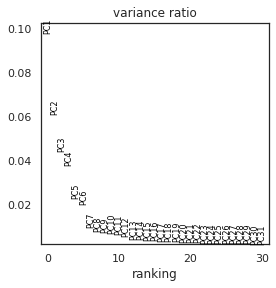

In [95]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata)

In [96]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:16)


/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


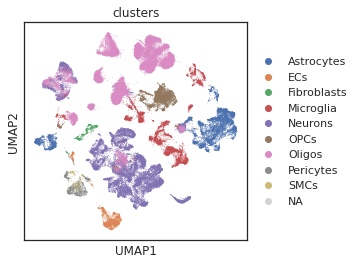

In [97]:
sc.pl.umap(adata, color='clusters')

### Marker genes

In [98]:
sc.tl.rank_genes_groups(adata, 'clusters')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:31)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`


/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


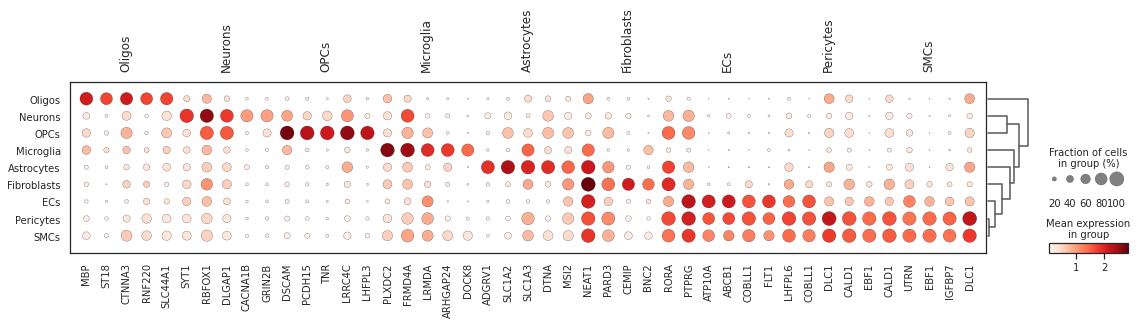

In [99]:
sc.pl.rank_genes_groups_dotplot(adata,n_genes=5)

### Focus on: Foxf2

In [120]:
gene="FOXF2"

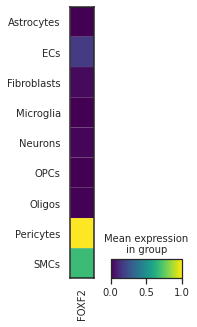

In [121]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


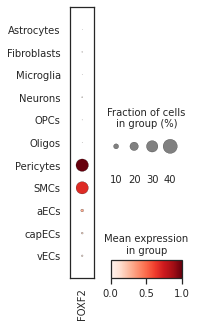

In [122]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

## Merge

In [123]:
adata = anndata.concat([adata, ad_ROSMAP], join="inner") # ignore batch effects etc because data is pre-annotated

In [124]:
adata

AnnData object with n_obs × n_vars = 96039 × 26812
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'celltype', 'clusters', 'clusters2'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'normalized'

# Focus on: Foxf2

In [125]:
gene="FOXF2"

## Plot

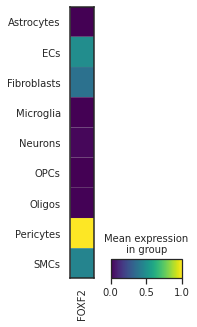

In [126]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

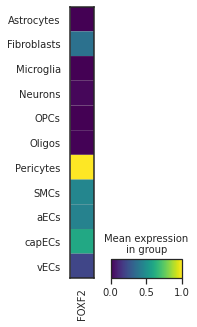

In [127]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


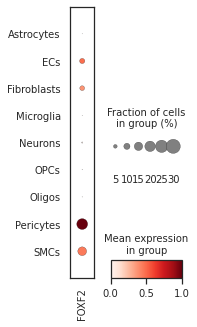

In [128]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


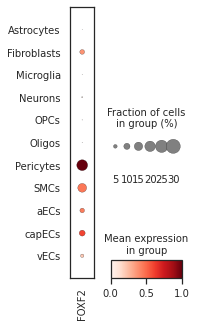

In [129]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

## Excl zonation

In [130]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000000
ECs,0.484664
Fibroblasts,0.372075
Microglia,0.003763
Neurons,0.016258
OPCs,0.003067
Oligos,0.007142
Pericytes,1.000000
SMCs,0.452608


In [131]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.001673
ECs,0.078342
Fibroblasts,0.069930
Microglia,0.001960
Neurons,0.010973
OPCs,0.002738
Oligos,0.002209
Pericytes,0.211296
SMCs,0.157844


In [132]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Garcia2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000000,0.001673,FOXF2,Garcia2022,Human,11954
ECs,0.484664,0.078342,FOXF2,Garcia2022,Human,6561
Fibroblasts,0.372075,0.069930,FOXF2,Garcia2022,Human,4147
Microglia,0.003763,0.001960,FOXF2,Garcia2022,Human,8164
Neurons,0.016258,0.010973,FOXF2,Garcia2022,Human,23968
OPCs,0.003067,0.002738,FOXF2,Garcia2022,Human,5844
Oligos,0.007142,0.002209,FOXF2,Garcia2022,Human,29428
Pericytes,1.000000,0.211296,FOXF2,Garcia2022,Human,4922
SMCs,0.452608,0.157844,FOXF2,Garcia2022,Human,1039


In [133]:
# export
name='Garcia2022'

In [134]:
# Win
foxf2.to_csv(main_dir+'/Foxf2_summarized/'+ date.today().strftime("%Y%m%d")+'_'+name+'_normalized.csv',sep=';')

## Incl zonation

In [135]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [136]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [137]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Garcia2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000000,0.001673,FOXF2,Garcia2022,Human,11954
Fibroblasts,0.372839,0.069930,FOXF2,Garcia2022,Human,4147
Microglia,0.003770,0.001960,FOXF2,Garcia2022,Human,8164
Neurons,0.016292,0.010973,FOXF2,Garcia2022,Human,23968
OPCs,0.003073,0.002738,FOXF2,Garcia2022,Human,5844
Oligos,0.007156,0.002209,FOXF2,Garcia2022,Human,29428
Pericytes,1.000000,0.210868,FOXF2,Garcia2022,Human,4932
SMCs,0.458041,0.159378,FOXF2,Garcia2022,Human,1029
aECs,0.437518,0.066586,FOXF2,Garcia2022,Human,826


In [138]:
# Win
foxf2.to_csv(main_dir+'/Foxf2_summarized/incl_zonation/'+ date.today().strftime("%Y%m%d")+'_'+name+'_incl_zonation_normalized.csv',sep=';')

# Focus on: Other genes

## Foxo1

In [139]:
gene="FOXO1"

### Plot

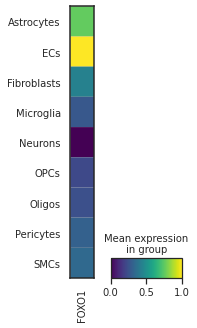

In [140]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

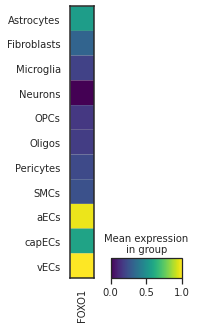

In [141]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


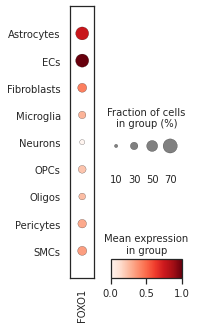

In [142]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


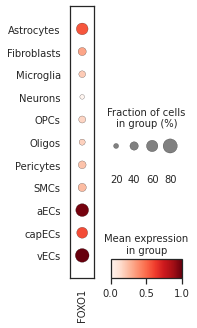

In [143]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [144]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.757857
ECs,1.000000
Fibroblasts,0.434439
Microglia,0.272508
Neurons,0.000000
OPCs,0.221826
Oligos,0.245925
Pericytes,0.306469
SMCs,0.336609


In [145]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.623641
ECs,0.632068
Fibroblasts,0.381481
Microglia,0.296791
Neurons,0.179740
OPCs,0.314853
Oligos,0.260466
Pericytes,0.359000
SMCs,0.386910


In [146]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Garcia2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.757857,0.623641,FOXO1,Garcia2022,Human,11954
ECs,1.000000,0.632068,FOXO1,Garcia2022,Human,6561
Fibroblasts,0.434439,0.381481,FOXO1,Garcia2022,Human,4147
Microglia,0.272508,0.296791,FOXO1,Garcia2022,Human,8164
Neurons,0.000000,0.179740,FOXO1,Garcia2022,Human,23968
OPCs,0.221826,0.314853,FOXO1,Garcia2022,Human,5844
Oligos,0.245925,0.260466,FOXO1,Garcia2022,Human,29428
Pericytes,0.306469,0.359000,FOXO1,Garcia2022,Human,4922
SMCs,0.336609,0.386910,FOXO1,Garcia2022,Human,1039


In [147]:
# export
name='Garcia2022'

In [148]:
# Win
foxf2.to_csv(main_dir+'/Others_summarized/'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [149]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [150]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [151]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Garcia2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.553711,0.623641,FOXO1,Garcia2022,Human,11954
Fibroblasts,0.317413,0.381481,FOXO1,Garcia2022,Human,4147
Microglia,0.199102,0.296791,FOXO1,Garcia2022,Human,8164
Neurons,0.000000,0.179740,FOXO1,Garcia2022,Human,23968
OPCs,0.162072,0.314853,FOXO1,Garcia2022,Human,5844
Oligos,0.179679,0.260466,FOXO1,Garcia2022,Human,29428
Pericytes,0.223665,0.358881,FOXO1,Garcia2022,Human,4932
SMCs,0.247348,0.387755,FOXO1,Garcia2022,Human,1029
aECs,0.968924,0.702179,FOXO1,Garcia2022,Human,826


In [152]:
# export
name='Garcia2022'

In [153]:
# Win
foxf2.to_csv(main_dir+'/Others_summarized/incl_zonation/'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## Tek = Tie2

In [154]:
gene="TEK"

### Plot

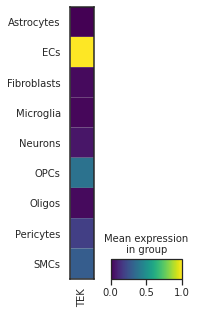

In [155]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

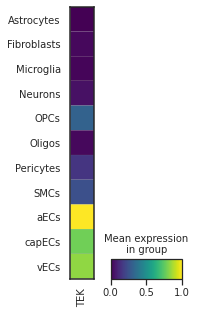

In [156]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


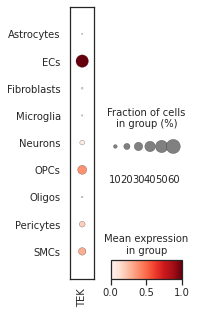

In [157]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


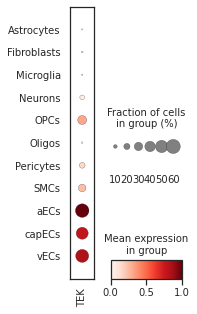

In [158]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [159]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000000
ECs,1.000000
Fibroblasts,0.025235
Microglia,0.016085
Neurons,0.055396
OPCs,0.376376
Oligos,0.026681
Pericytes,0.186347
SMCs,0.292215


In [160]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.023674
ECs,0.505411
Fibroblasts,0.036653
Microglia,0.027193
Neurons,0.137475
OPCs,0.324778
Oligos,0.030311
Pericytes,0.181837
SMCs,0.256978


In [161]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Garcia2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000000,0.023674,TEK,Garcia2022,Human,11954
ECs,1.000000,0.505411,TEK,Garcia2022,Human,6561
Fibroblasts,0.025235,0.036653,TEK,Garcia2022,Human,4147
Microglia,0.016085,0.027193,TEK,Garcia2022,Human,8164
Neurons,0.055396,0.137475,TEK,Garcia2022,Human,23968
OPCs,0.376376,0.324778,TEK,Garcia2022,Human,5844
Oligos,0.026681,0.030311,TEK,Garcia2022,Human,29428
Pericytes,0.186347,0.181837,TEK,Garcia2022,Human,4922
SMCs,0.292215,0.256978,TEK,Garcia2022,Human,1039


In [162]:
# export
name='Garcia2022'

In [163]:
# Win
foxf2.to_csv(main_dir+'/Others_summarized/'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [164]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [165]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [166]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Garcia2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000000,0.023674,TEK,Garcia2022,Human,11954
Fibroblasts,0.020750,0.036653,TEK,Garcia2022,Human,4147
Microglia,0.013226,0.027193,TEK,Garcia2022,Human,8164
Neurons,0.045549,0.137475,TEK,Garcia2022,Human,23968
OPCs,0.309474,0.324778,TEK,Garcia2022,Human,5844
Oligos,0.021938,0.030311,TEK,Garcia2022,Human,29428
Pericytes,0.152874,0.181468,TEK,Garcia2022,Human,4932
SMCs,0.242788,0.259475,TEK,Garcia2022,Human,1029
aECs,1.000000,0.566586,TEK,Garcia2022,Human,826


In [167]:
# export
name='Garcia2022'

In [168]:
# Win
foxf2.to_csv(main_dir+'/Others_summarized/incl_zonation/'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## Nos3 = eNOS

In [169]:
gene="NOS3"

### Plot

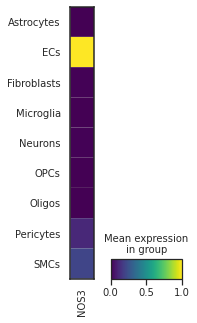

In [170]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

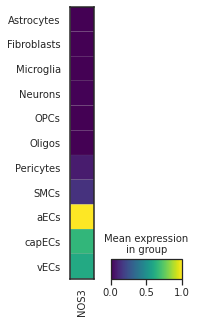

In [171]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


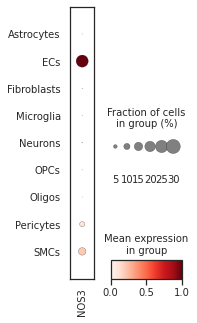

In [172]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/cluster2/sfrerich/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


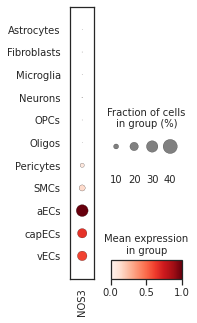

In [173]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [174]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000018
ECs,1.000000
Fibroblasts,0.004909
Microglia,0.003034
Neurons,0.005833
OPCs,0.000000
Oligos,0.002094
Pericytes,0.110679
SMCs,0.205483


In [175]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.002008
ECs,0.243865
Fibroblasts,0.003135
Microglia,0.002327
Neurons,0.005090
OPCs,0.002396
Oligos,0.001733
Pericytes,0.079033
SMCs,0.128970


In [176]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Garcia2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000018,0.002008,NOS3,Garcia2022,Human,11954
ECs,1.000000,0.243865,NOS3,Garcia2022,Human,6561
Fibroblasts,0.004909,0.003135,NOS3,Garcia2022,Human,4147
Microglia,0.003034,0.002327,NOS3,Garcia2022,Human,8164
Neurons,0.005833,0.005090,NOS3,Garcia2022,Human,23968
OPCs,0.000000,0.002396,NOS3,Garcia2022,Human,5844
Oligos,0.002094,0.001733,NOS3,Garcia2022,Human,29428
Pericytes,0.110679,0.079033,NOS3,Garcia2022,Human,4922
SMCs,0.205483,0.128970,NOS3,Garcia2022,Human,1039


In [177]:
# export
name='Garcia2022'

In [178]:
# Win
foxf2.to_csv(main_dir+'/Others_summarized/'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [179]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [180]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [181]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Garcia2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000012,0.002008,NOS3,Garcia2022,Human,11954
Fibroblasts,0.003375,0.003135,NOS3,Garcia2022,Human,4147
Microglia,0.002086,0.002327,NOS3,Garcia2022,Human,8164
Neurons,0.004010,0.005090,NOS3,Garcia2022,Human,23968
OPCs,0.000000,0.002396,NOS3,Garcia2022,Human,5844
Oligos,0.001439,0.001733,NOS3,Garcia2022,Human,29428
Pericytes,0.075924,0.078873,NOS3,Garcia2022,Human,4932
SMCs,0.142674,0.130224,NOS3,Garcia2022,Human,1029
aECs,1.000000,0.315981,NOS3,Garcia2022,Human,826


In [182]:
# export
name='Garcia2022'

In [183]:
# Win
foxf2.to_csv(main_dir+'/Others_summarized/incl_zonation/'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

# Session Info

In [184]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.4.0
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.1
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
h5py                        3.8.0
ipykernel                   6.9.1
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
joblib                      1.2.0
jupyter_server              1.23.4
kiwisolver                  1.4.4
llvmlite                    0.39.1
loompy                      3.0.7
matplotlib                  3.6.3
matplotlib_inline           NA
mpl_toolkits                NA
natsort                     8.2.0
numba                       0.56.4
numexpr                     2.8.4
numpy   